# LGS: Off-Axis Source Model (UA Testbed)
## Goal:
- Make an off-axis source model for the UA Testbed! Then I can add in all the other stuff (vAPP, pupil, etc)

## Notes:
- <b>UA Testbed Design Version</b>: 2016/09/26, Kelsey Miller. See data/Testbed_Layout_Schematic_Oct_2016.pdf for additional details.
- The UA testbed models phase 1, which replaces OAP4 with the characteristics of OAP1/2/3. There are some angle changes and additional optics in place not shown in the design.
- This version currently has no surface maps implemented, it'll be added soon enough.
- The F/# focal plane generation is pre-calculated elsewhere.
- The testbed uses a diverging beam source, so this notebook "fakes" it in with a negative lens.

In [1]:
%matplotlib inline
import numpy as np

# plotting tools
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import matplotlib

# units
from astropy import units as u
from astropy.io import fits

# POPPY
import poppy
from poppy.poppy_core import PlaneType
poppy.__version__

# Import external functions file; mostly pulled from magaox_poppy
# import magaoxFunctions as mf

'0.6.0rc1'

## Initiate the optical elements and variables
### Optical elements not implemented:
- BMC 1K DM powered flat surface (in testing)
- IrisAO DM powered flat surface (in testing)

### Assumptions made:
- Deformable mirrors (Iris AO, BMC 1K) are implemented as perfect surface flat mirrors. 
- Imaging lens not decided yet, so using f=100mm until Kelsey makes a decision.

In [2]:
# define system parameters
EP_diam = 0.008 * u.m # currently oversizing the EP diameter, hopefully it does not hurt later at vAPP
oversamp = 0.125
samp = 256

halpha = 656e-9 * u.m

# define physical sizes; using 2inch diameter for placeholders
# The placeholders don't hurt (for now)
oap_radius = 0.0254 * u.m # 2 inch diameter
irisAO_radius = 0.0254 * u.m # placeholder
BMC1K_radius = 0.0254 * u.m # placeholder
colLens_radius = 0.0254 * u.m # I think it's a 2 inch diameter
imgLens_radius = 0.0254 * u.m # Assuming 2 inch diameter

# define focal lengths
fl_OAP = 0.273 * u.m # all OAPs are the same focal length
fl_colLens = 0.350 * u.m # selected for resizing vAPP incoming beam
fl_imgLens = 0.100 * u.m # Placeholder until lens is selected

# define distances
d_src_oap1 = fl_OAP
d_oap1_pp1 = fl_OAP
d_pp1_oap2 = fl_OAP
d_oap2_fp1 = fl_OAP
d_fp1_oap3 = fl_OAP
d_oap3_pp2 = fl_OAP
d_pp2_oap4 = fl_OAP
d_oap4_fp2 = fl_OAP
d_fp2_colLens = fl_colLens
d_colLens_vAPP = fl_colLens
d_vAPP_imgLens = fl_imgLens
d_imgLens_camera = fl_imgLens

# focal plane correction distances, calculated in the past
f39f1_delta = -3.4653763e-6 * u.m
f39f2_delta = -3.4652003e-6 * u.m

# initialize optical elements
diverge_source = poppy.QuadraticLens(-(d_src_oap1),name='Diverging Source') 
# finite distance source is a negative lens to simulate dispersive source
colLens = poppy.QuadraticLens(fl_colLens, name='Collimating Lens')
imgLens = poppy.QuadraticLens(fl_imgLens, name='Imaging Lens')

# Declare OAP mirrors
OAP1 = poppy.QuadraticLens(fl_OAP, name='OAP-1')
OAP2 = poppy.QuadraticLens(fl_OAP, name='OAP-2')
OAP3 = poppy.QuadraticLens(fl_OAP, name='OAP-3')
OAP4 = poppy.QuadraticLens(fl_OAP, name='OAP-4')

vAPP Mask files. The cell may not work if I didn't upload the vAPP mask files or my externalFunctions file, but it can be skipped to get the science PSF.

In [ ]:
vapp_phase_data = fits.open('data/coronagraph/MagAOx_256x256_phase_nograting.fits')[0].data
vapp_aperture_data = fits.open('data/coronagraph/MagAOx_256x256_amp.fits')[0].data

vAPP_folder = 'data/coronagraph/'
vAPP_diam = 0.0086 # units: meters. Kelsey selected 8.6mm beam diameter at vAPP.
vAPP_pixelscl = vAPP_diam/samp # vAPP is sized to whatever the sampling is set.

vapp_opd_surf_data = 1*(halpha.value/(2*np.pi))*vapp_phase_data*vapp_aperture_data
vAPP_opd_filename = 'vAPP_opd_mask_1PSF_256'
mf.writeOPDfile(vapp_opd_surf_data, vAPP_pixelscl, vAPP_folder + vAPP_opd_filename + '.fits')

vAPP_trans_filename = 'vAPP_trans_mask_1PSF_256'
mf.writeTRANSfile(vapp_aperture_data, vAPP_pixelscl, vAPP_folder + vAPP_trans_filename + '.fits')

Skip this line for now too

In [ ]:
pupil = mf.surfFITS(file_loc='data/UAWFStebsted_MagAOpupil.fits', optic_type='trans', opdunit='none', 
                 name='MagAO Pupil (masked)')
vapp_opd = mf.surfFITS(file_loc=vAPP_folder+vAPP_opd_filename+'.fits', optic_type='opd', opdunit='meters', 
                      name='vAPP mask (OPD)')
vapp_trans = mf.surfFITS(file_loc=vAPP_folder+vAPP_trans_filename+'.fits', optic_type='trans', opdunit='none', 
                      name='vAPP mask (transmission)')

## Build the testbed

In [3]:
# Initialize FresnelOpticalSystem
uawfstb = poppy.FresnelOpticalSystem(pupil_diameter = EP_diam, npix=samp, beam_ratio=oversamp)

# First surface is the entrance aperture.
uawfstb.add_optic(poppy.CircularAperture(radius=EP_diam/2))

# To simulate a diverging pt source, use a negative-power lens with focal length -d, 
# where d is distance prior to entrance aperture
uawfstb.add_optic(diverge_source)

# OAP1
uawfstb.add_optic(OAP1)
uawfstb.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP1 aperture"))

# First Pupil Plane: placement of IrisAO DM or MagAO pupil.
uawfstb.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="1st Pupil Plane"), 
                                            distance=d_oap1_pp1)
# Placeholder for pupil until I scale the pupil mask correctly
uawfstb.add_optic(poppy.CircularAperture(radius=0.00335*u.m, name='6.7mm pupil'))
#uawfstb.add_optic(pupil)

# IrisAO DM, currently a "perfect" mirror
#uawfstb.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="IrisAO DM"))
#uawfstb.add_optic(poppy.CircularAperture(radius=irisAO_radius,name="IrisAO aperture"))

# OAP2
uawfstb.add_optic(OAP2, distance=d_pp1_oap2)
uawfstb.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP2 aperture"))

# F/39 focal plane
uawfstb.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/39 focal plane"), 
                                            distance=d_oap2_fp1+f39f1_delta)

# add in OAP3
uawfstb.add_optic(OAP3, distance=d_fp1_oap3)
uawfstb.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP3 aperture"))

# Second pupil plane: BMC 1K DM, currently a "perfect" mirror
uawfstb.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="BMC 1K DM / 2nd Pupil Plane"), 
                                            distance=d_oap3_pp2)
uawfstb.add_optic(poppy.CircularAperture(radius=BMC1K_radius,name="BMC 1K DM aperture"))

# OAP4
uawfstb.add_optic(OAP2, distance=d_pp2_oap4)
uawfstb.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP4 aperture"))

# Second F/39 focal plane
uawfstb.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="Second F/39 focal plane"), 
                                            distance=d_oap4_fp2+f39f2_delta)

# Collimating lens to form pupil plane for vAPP mask
uawfstb.add_optic(colLens, distance=d_fp2_colLens)
uawfstb.add_optic(poppy.CircularAperture(radius=colLens_radius,name="collimating lens aperture"))

# vAPP pupil plane
#uawfstb.add_optic(vapp_trans, distance=d_colLens_vAPP)
#uawfstb.add_optic(vapp_opd)
uawfstb.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="vAPP Pupil Plane"), 
                                            distance=d_colLens_vAPP)
uawfstb.add_optic(poppy.CircularAperture(radius=0.0086/2*u.m,name="vAPP aperture"))

# Imaging lens
uawfstb.add_optic(imgLens, distance=d_vAPP_imgLens)
uawfstb.add_optic(poppy.CircularAperture(radius=imgLens_radius,name='Imaging lens aperture'))

# "Camera" for science PSF
uawfstb.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="Science Camera"), 
                                            distance=d_imgLens_camera)

Include the off-axis information (not sure if this will work)

In [4]:
uawfstb.source_offset_theta = 15.
uawfstb.source_offset_r = 0.1 # arcsec

/home/jhen/anaconda3/lib/python3.5/site-packages/astropy/units/quantity.py:858: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)


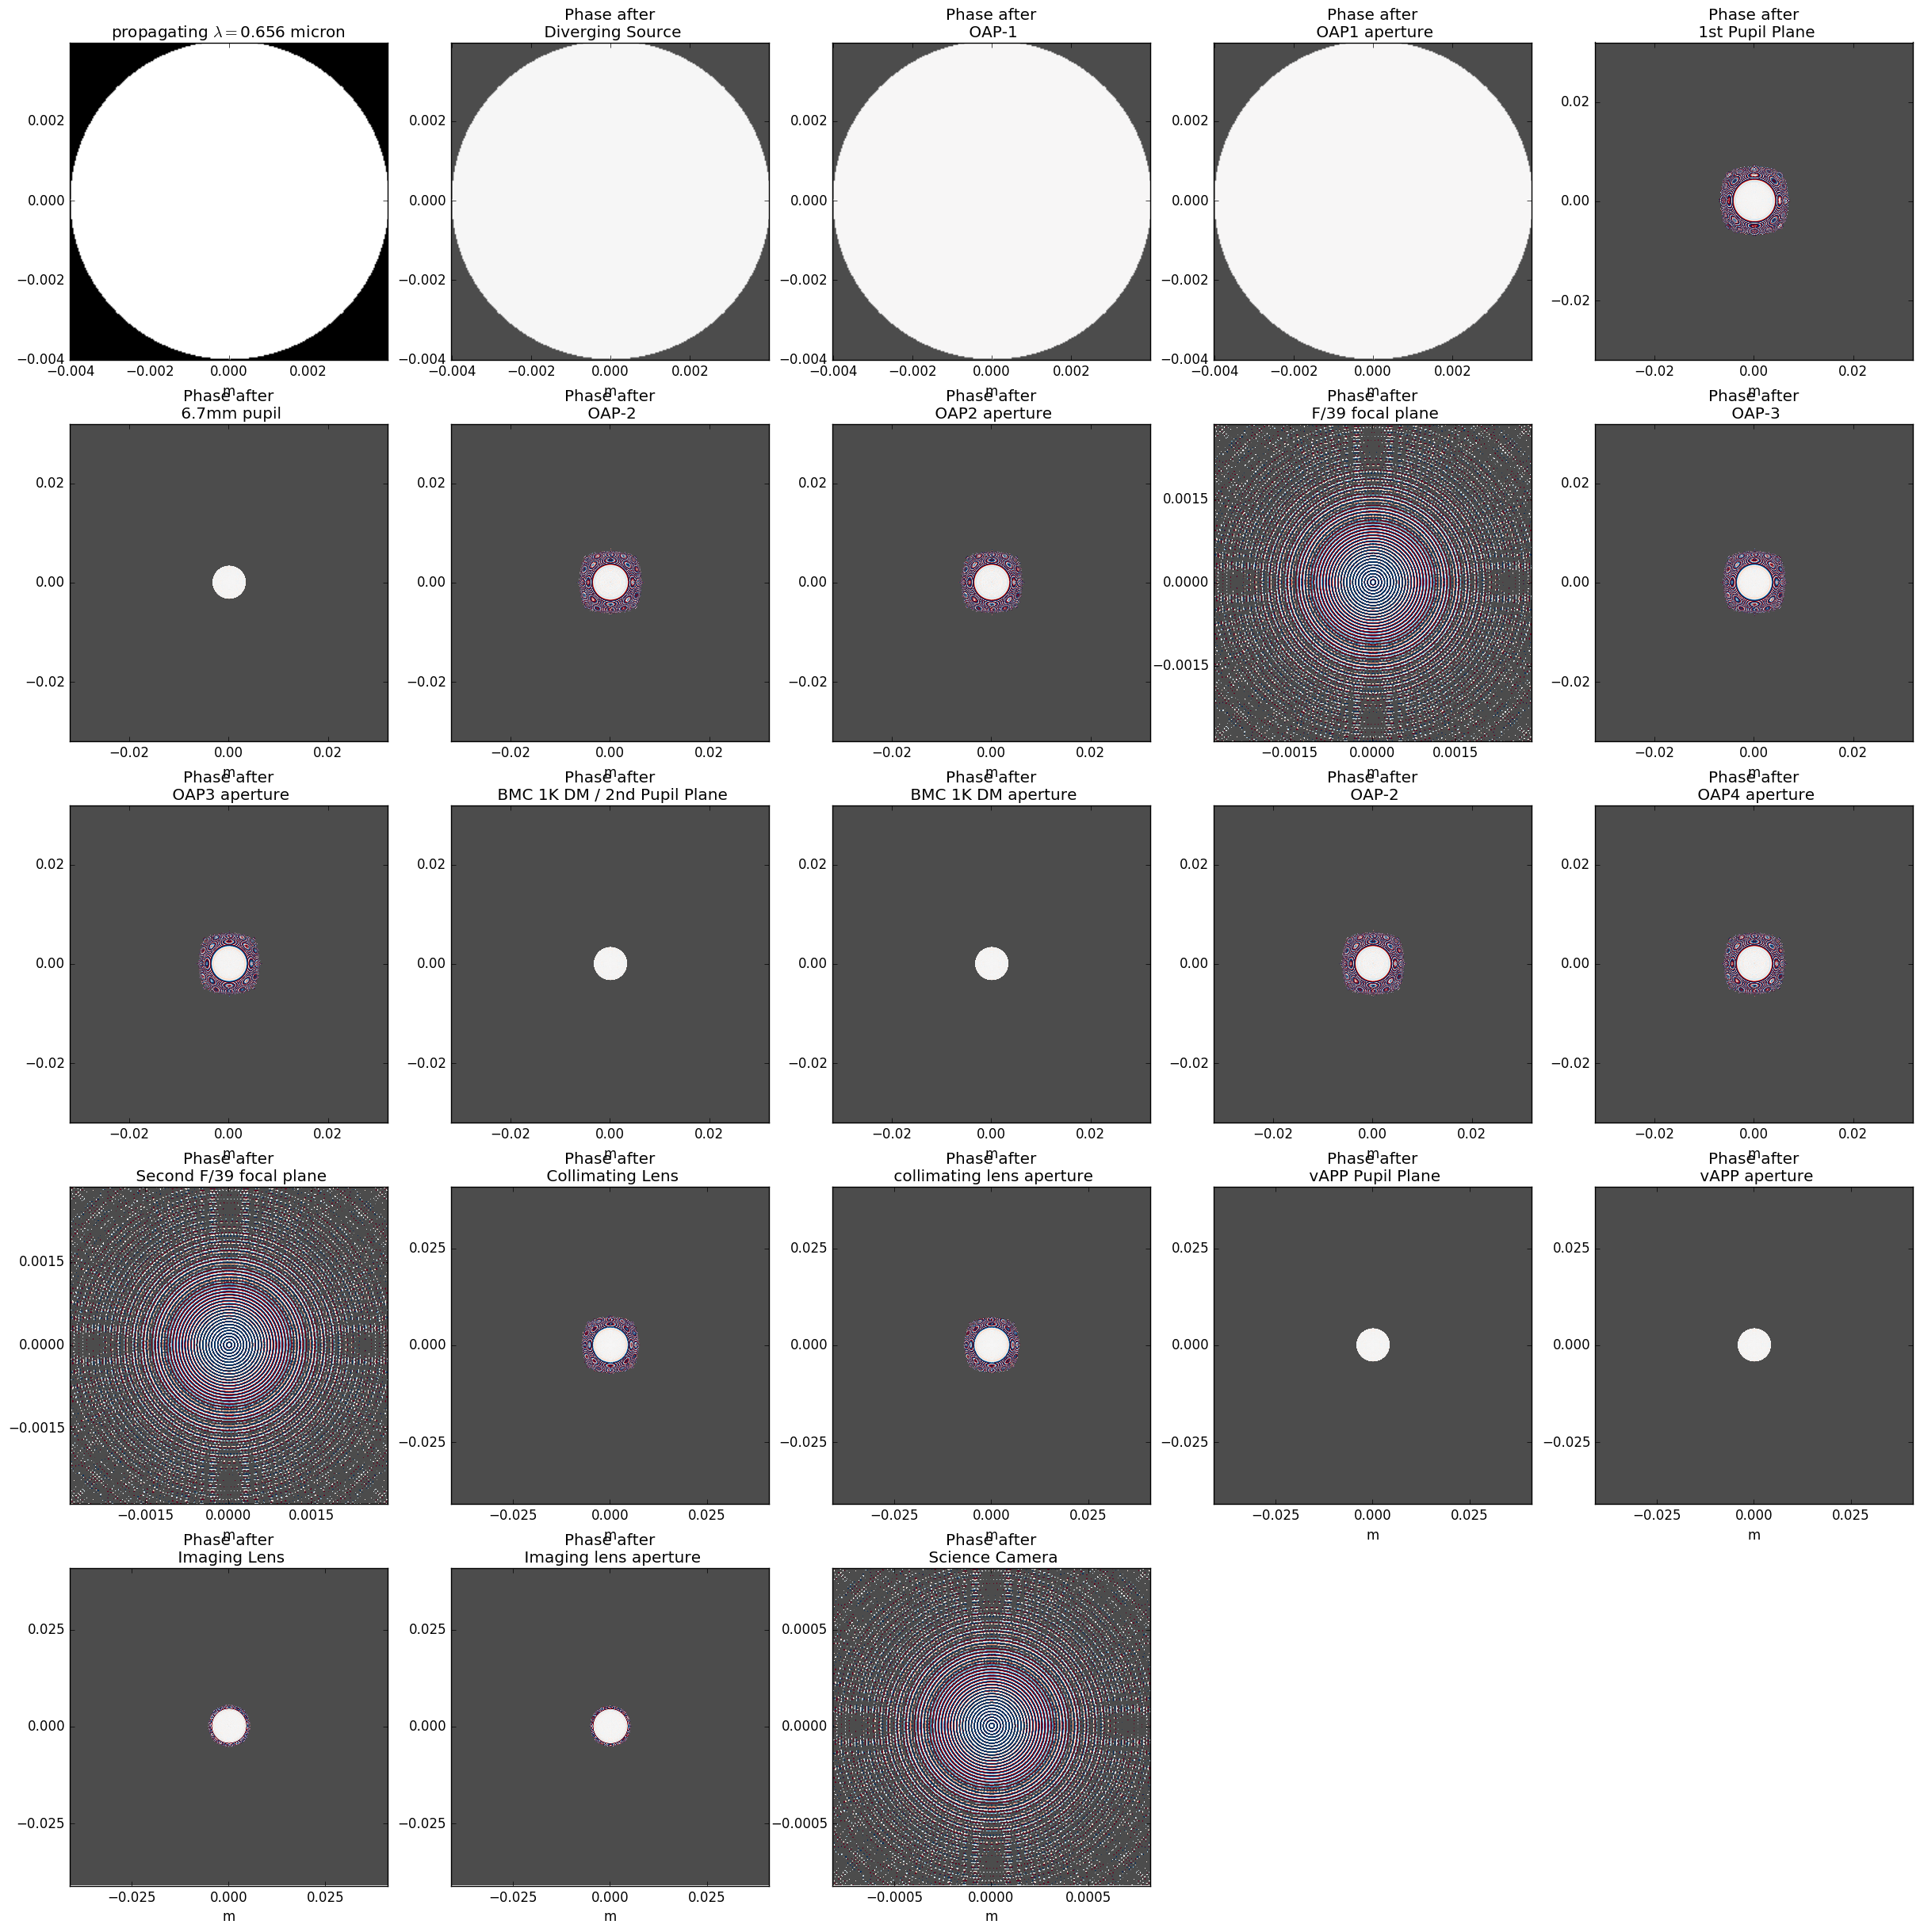

In [5]:
matplotlib.rcParams["font.size"]=12
plt.figure(figsize=[30,30])
lgs_psf, lgs_wfs = uawfstb.calcPSF(wavelength=halpha, 
                                        display_intermediates=True, 
                                        return_intermediates=True, save_intermediates=False)

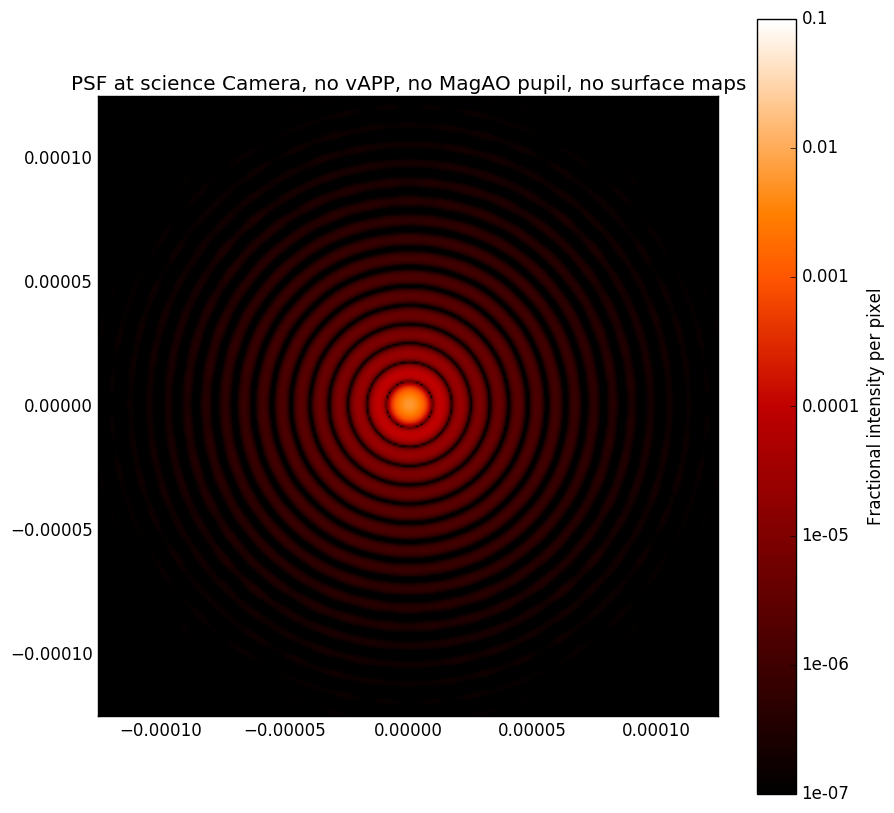

In [6]:
plt.figure(figsize=[10,10])
poppy.display_PSF(lgs_psf, imagecrop=0.00025)
plt.title("PSF at science Camera, no vAPP, no MagAO pupil, no surface maps")

In [7]:
uawfstb.describe()

	Entrance pupil diam:  0.008 m	npix: 256	Beam ratio:0.125
	Optic: Circle, radius=0.004 m
	Lens: Diverging Source, with focal length -0.273 m
	Lens: OAP-1, with focal length 0.273 m
	Optic: OAP1 aperture
	Propagation distance:  0.273 m
	Optic: 1st Pupil Plane
	Optic: 6.7mm pupil
	Propagation distance:  0.273 m
	Lens: OAP-2, with focal length 0.273 m
	Optic: OAP2 aperture
	Propagation distance:  0.2729965346237 m
	Optic: F/39 focal plane
	Propagation distance:  0.273 m
	Lens: OAP-3, with focal length 0.273 m
	Optic: OAP3 aperture
	Propagation distance:  0.273 m
	Optic: BMC 1K DM / 2nd Pupil Plane
	Optic: BMC 1K DM aperture
	Propagation distance:  0.273 m
	Lens: OAP-2, with focal length 0.273 m
	Optic: OAP4 aperture
	Propagation distance:  0.27299653479970004 m
	Optic: Second F/39 focal plane
	Propagation distance:  0.35 m
	Lens: Collimating Lens, with focal length 0.35 m
	Optic: collimating lens aperture
	Propagation distance:  0.35 m
	Optic: vAPP Pupil Plane
	Optic: vAPP aperture
	Propa